In [1]:
# imports
import os
import sys
import time
# add to the path the source files
sys.path.append(os.path.dirname(os.getcwd()))

import wandb
import numpy as np
import pandas as pd
from copy import deepcopy
from dgl.data.utils import load_graphs
import dgl
import torch 
import torch.nn as nn
import torch_geometric 
from torch_geometric.loader import DataLoader
import networkx as nx
from src.dataset.counting_algorithm import subgraph_counting
#from src.baseline.model_gcn import GCN, GIN
from src.baseline.dataset_gcn import GraphDataset
from src.metrics.L1_based import L1LossCount, L1LossStd
from matplotlib import pyplot as plt
from src.baseline.model_gcn import GCN, GIN
from src.ppgn.ppgn import PPGN
import json

def generate_gnn_input(graph: nx.Graph, device)->torch_geometric.data.Data:
    """Creates from a networkx graph a Data instance, which is the input a a pytorch geometric model."""
    x = torch.ones(graph.number_of_nodes(), 1) # no improovement by using more channels in the first layer
    edge_index = torch.empty(2, graph.number_of_edges(), dtype=torch.long)
    for i, edge in enumerate(graph.edges()):
        edge_index[0,i] = edge[0]
        edge_index[1,i] = edge[1]
    return torch_geometric.data.Data(x=x, edge_index=edge_index).to(device)

loss_fn = torch.nn.L1Loss()

In [ ]:
# robustness greedy
from src.adversarial.greedy_attack import GreedyAttack, Preserve2GreedyAttack, PreserveGreedyAttack

from joblib import Parallel, delayed

task = 'Triangle'
device = 'cpu'
dataset_path = "/nfs/students/campi/dataset/training/test_5000_er_10.bin"
models_path = [f"//nfs/students/campi/best_models/PPGN_er_10/PPGN_{task}_{i}.pth" for i in range(5)]
dict_path = [f"//nfs/students/campi/best_models/PPGN_er_10/PPGN_{task}_{i}.json" for i in range(5)]
i = 1
with open(dict_path[0], 'r') as f:
    h_params = json.load(f)
gnn = PPGN(**h_params)
gnn.load_state_dict(torch.load(models_path[0], map_location=torch.device(device)))

graphs, counts = dgl.load_graphs(dataset_path)
graph = nx.Graph(dgl.to_networkx(graphs[i]))
count = counts[task][i]

start = time.time()
greedy_attack = Preserve2GreedyAttack(edge_addition=True, edge_deletion=True, device=device)
adversarial_graph, adversarial_error_history, adversarial_count = greedy_attack.find_adversarial_example(budget=2, gnn=gnn, loss_fn=loss_fn, graph=graph,subgraph_type=task,count=count)
print(f'{adversarial_error_history}, time: {time.time() - start}')

start = time.time()
greedy_attack = PreserveGreedyAttack(edge_addition=True, edge_deletion=True, device=device)
adversarial_graph, adversarial_error_history, adversarial_count = greedy_attack.find_adversarial_example(budget=4, gnn=gnn, loss_fn=loss_fn, graph=graph,subgraph_type=task,count=count)
print(f'{adversarial_error_history}, time: {time.time() - start}')




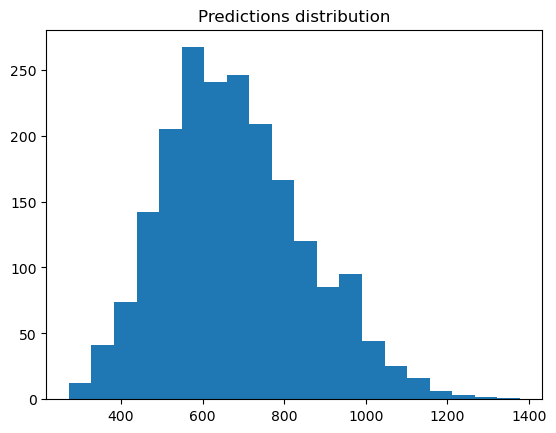

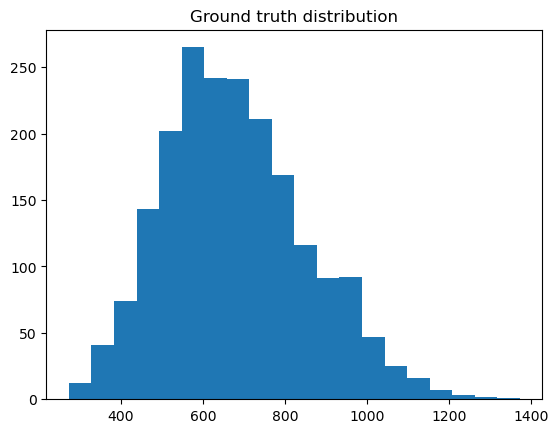

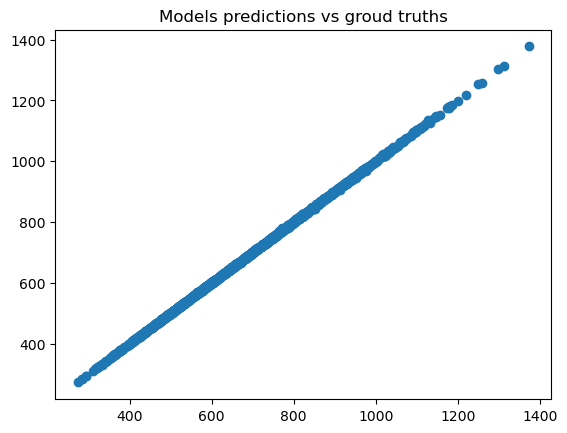

In [2]:
import json
from src.ppgn.ppgn import PPGN

task = 'g44'
device = 'cuda'
ppgns = []
path = f"/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/models/PPGN_er_50/PPGN_g44_6_1"
with open(path + ".json", 'r') as fp:
    h_params = json.load(fp)
ppgn = PPGN(**h_params).to(device)
ppgn.load_state_dict(torch.load(path + ".pth"))

val_dataset = GraphDataset(dataset_path="../data/training/validation_10000_er_50.bin", task=task, in_channels=1)
dataloader_loss = DataLoader(val_dataset, batch_size=128)

preds = []
gt = []
with torch.no_grad():
    for data, y in dataloader_loss:
        data = data.to(device)
        y = y.to(device)
        pred = ppgn(data)
        preds.extend(pred.flatten().tolist())
        gt.extend(y.flatten().tolist())
plt.hist(preds, bins=20)
plt.title("Predictions distribution")
plt.show()
plt.hist(gt, bins=20)
plt.title("Ground truth distribution")
plt.show()
plt.scatter(gt, preds)
plt.title("Models predictions vs groud truths")
plt.show()

In [23]:
import torch
t = torch.zeros(3)
print(t.shape)
t = torch.unsqueeze(t, -1)
print(t.shape)

torch.Size([3])
torch.Size([3, 1])


tensor([[-0.1637]], device='cuda:0', grad_fn=<AddmmBackward0>)
6.0


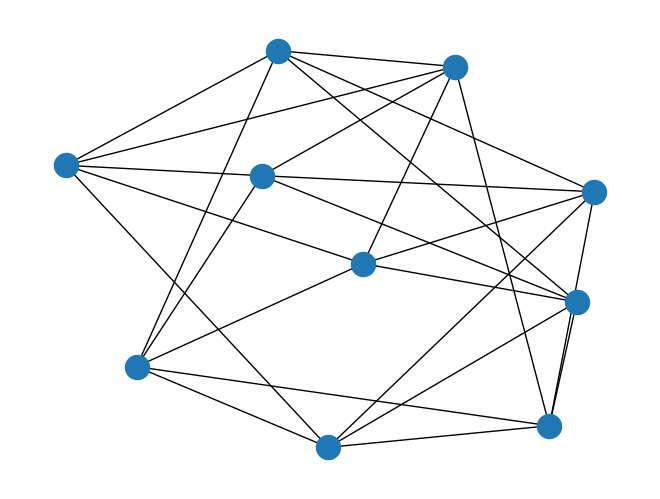

In [10]:
import networkx as nx
import torch
import os
import sys
# add to the path the source files
sys.path.append(os.path.dirname(os.getcwd()))
from src.baseline.model_gcn import GIN
from src.dataset.counting_algorithm import subgraph_counting
graph = nx.Graph(np.load("/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/graphs/GIN_98_g42_0.npy", allow_pickle=True)[0])
count = np.load("/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/graphs/GIN_98_g42_0.npy", allow_pickle=True)[1]
gnn = torch.load("/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/models/GIN/GIN_g42_4.pkl")
print(gnn(generate_gnn_input(graph, 'cuda')))
nx.draw(graph)

print(count)

In [13]:
train_dataset = '/nfs/students/campi/dataset/training/validation_5000_er_30.bin'
nodes = train_dataset.split('/')[-1].split('.')[0].split('_')[-1]
print(nodes)

30
